# Python 3 working kernel Change the stock

## This notebook optimize the hyper parameters: ma, skip, max_buy, max_sell by GA
## kernel Py363_Adrain


In [1]:
import mysql.connector
from mysql.connector import errorcode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import datetime as dt
from matplotlib import style
import pandas_datareader.data as web # pip install pandas_datareader
from datetime import date, datetime, timedelta
#from datetime import timedelta
from dateutil.relativedelta import *
import seaborn as sns
sns.set()

style.use('ggplot')



In [2]:
# Stock id
stock_id =1

# Query Initialization
get_stock_id_query = '''select count(id) from stock_data'''
insert_stock_query ='''insert into stock_data (id, name, date_begin) Values ('{0}', '{1}', '{2}')'''
insert_stock_query ='''insert into stock_data (id, name, date_begin) Values ('{0}', '{1}', '{2}')'''
insert_metrics_query='''insert into metrics_setting (stock_id, meta_id, setting_skip_loop, setting_ma, \
setting_max_buy, ROI, Sharpe, Sortino) Values ({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7})'''


def connect_to_mysql():
    try: 
        print("connect")
        cnx=mysql.connector.connect(host='localhost', user='root', password='temptemp88', port='3306', database='stock_ROI')
        return cnx
    except mysql.connect.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print('Something is wrong with username and password')
        elif err.errno== errorcode.ER_BAD_DB_ERROR:
            print("database does not exist")
        else:
            print(err)
        return err
    
def get_stock_id():
    cnx = connect_to_mysql()
    cursor = cnx.cursor()
    cursor.execute(get_stock_id_query)
    stock_id = list(cursor)[0][0] +1
    print('stock_id=',stock_id)
    cnx.close()
    return(stock_id)        
def insert_stock(stock_id, Stock, start):
    cnx = connect_to_mysql()
    cursor = cnx.cursor()
    cursor.execute(insert_stock_query.format(stock_id, Stock, start))
    cnx.commit()
    cnx.close()
def insert_metrics_setting(stock_id, meta_id,  setting_skip_loop, setting_ma,setting_max_buy, ROI, Sharpe, Sortino):
    cnx = connect_to_mysql()
    cursor = cnx.cursor()
    cursor.execute(insert_metrics_query.format(stock_id, meta_id,  setting_skip_loop, setting_ma,setting_max_buy, ROI, Sharpe, Sortino))
    cnx.commit()

## Load data and Train Test Split

In [3]:
# choose stock
Stock = 'AAPL'
trading_period = 365
stock_id = get_stock_id()
start = dt.datetime(2017,5,23)
insert_stock(stock_id, Stock, start)

connect
stock_id= 12
connect


In [4]:
# get last 1 year data from Yahoo Finance for training

#end = dt.datetime(2018,  4,24)
end = start + timedelta(days=trading_period)
df = web.DataReader(Stock,'yahoo',  start,end)
X_train = df.dropna()
#X_train = X_train.divide(X_train.iloc[0] )
file_name_train = 'dataset/'+Stock+'_train.csv'
display(file_name_train)
X_train.to_csv(file_name_train, sep=',', encoding='utf-8')
print(X_train.head())

'dataset/AAPL_train.csv'

                  High         Low        Open       Close      Volume  \
Date                                                                     
2017-05-22  154.580002  152.910004  154.000000  153.990005  22966400.0   
2017-05-23  154.899994  153.309998  154.899994  153.800003  19918900.0   
2017-05-24  154.169998  152.669998  153.839996  153.339996  19178000.0   
2017-05-25  154.350006  153.029999  153.729996  153.869995  19235600.0   
2017-05-26  154.240005  153.309998  154.000000  153.610001  21927600.0   

             Adj Close  
Date                    
2017-05-22  149.359360  
2017-05-23  149.175079  
2017-05-24  148.728882  
2017-05-25  149.242950  
2017-05-26  148.990768  


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2017-05-22 to 2018-05-23
Data columns (total 6 columns):
High         254 non-null float64
Low          254 non-null float64
Open         254 non-null float64
Close        254 non-null float64
Volume       254 non-null float64
Adj Close    254 non-null float64
dtypes: float64(6)
memory usage: 13.9 KB


In [6]:
# get current 1 year data from Yahoo Finance for testing
#start = dt.datetime(2018,4,24)
#end = dt.datetime(2019,  4,24)
start_testing = end 
end_testing = start_testing+timedelta(days=trading_period)


df = web.DataReader(Stock,'yahoo',  start_testing,end_testing)
X_test = df.dropna()
file_name_test = 'dataset/'+Stock+'_test.csv'
display(file_name_test)
X_test.to_csv(file_name_test, sep=',', encoding='utf-8')

print(X_test.head())

'dataset/AAPL_test.csv'

                  High         Low        Open       Close      Volume  \
Date                                                                     
2018-05-22  188.880005  186.779999  188.380005  187.160004  15240700.0   
2018-05-23  188.500000  185.759995  186.350006  188.360001  20058400.0   
2018-05-24  188.839996  186.210007  188.770004  188.149994  23234000.0   
2018-05-25  189.649994  187.649994  188.229996  188.580002  17461000.0   
2018-05-29  188.750000  186.869995  187.600006  187.899994  22514100.0   

             Adj Close  
Date                    
2018-05-22  184.353760  
2018-05-23  185.535767  
2018-05-24  185.328918  
2018-05-25  185.752487  
2018-05-29  185.082672  


In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2018-05-22 to 2019-05-23
Data columns (total 6 columns):
High         253 non-null float64
Low          253 non-null float64
Open         253 non-null float64
Close        253 non-null float64
Volume       253 non-null float64
Adj Close    253 non-null float64
dtypes: float64(6)
memory usage: 13.8 KB


In [8]:
#prefix = 'Fig/GLD_'
prefix = 'Fig/' +Stock +'_'

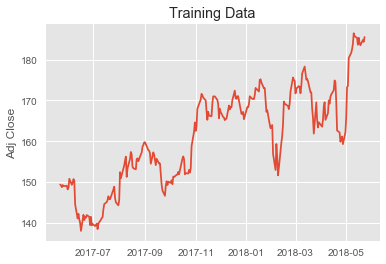

In [9]:
plt.plot(X_train['Adj Close'])
plt.ylabel('Adj Close')
plt.title('Training Data')
filename =prefix + 'Training_Chart.png'
plt.savefig(filename)

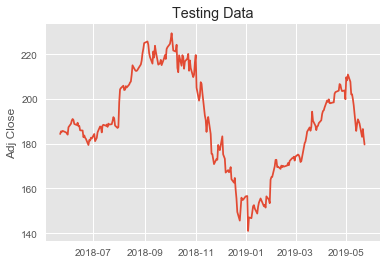

In [10]:
plt.plot(X_test['Adj Close'])
plt.ylabel('Adj Close')
plt.title('Testing Data')
filename = prefix + 'Testing_Chart.png'
plt.savefig(filename)

In [11]:
X_train.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,166.052756,163.400985,164.725630,164.749291,3.034867e+07,160.837324
std,11.567923,11.459870,11.413267,11.515264,1.258306e+07,11.859947
min,143.500000,142.199997,142.899994,142.270004,1.402670e+07,137.991791
25%,157.004997,154.499996,155.849998,155.480000,2.157180e+07,151.386440
50%,167.454994,163.904999,165.599998,165.489998,2.670500e+07,162.249199
75%,175.044998,172.660004,173.677494,174.127499,3.542170e+07,170.098068
max,190.369995,187.860001,189.490005,190.039993,8.659380e+07,186.471527


In [12]:
X_test.describe()

,High,Low,Open,Close,Volume,Adj Close
count,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000
mean,193.500870,189.694703,191.591463,191.681146,3.224954e+07,189.909908
std,21.492151,21.212220,21.312382,21.334579,1.407737e+07,20.906297
min,145.720001,142.000000,143.979996,142.190002,1.251390e+07,141.039642
25%,176.000000,173.949997,174.940002,174.970001,2.273770e+07,174.298782
50%,191.970001,189.309998,190.679993,190.800003,2.879210e+07,188.362747
75%,210.059998,206.759995,208.000000,208.869995,3.861230e+07,206.684052
max,233.470001,229.779999,230.779999,232.070007,9.624670e+07,229.392090


In [13]:
#df = pd.read_csv('../dataset/GOOG-year.csv')
#df.head()

In [14]:
def get_return(stock_array):
    return (stock_array[1:]-stock_array[0:-1])/stock_array[0:-1]

In [15]:
def get_buy_and_hold_ROI(X):
    
    #X = X_train
    max_share = 10000/X['Adj Close'][0:10].mean()
    begin_mean = X['Adj Close'][0:10].mean()
    end_mean = X['Adj Close'][-11:-1].mean()
    No_share = np.floor(max_share)
    cash = 10000-No_share* begin_mean
    Asset_begin = No_share* begin_mean +cash
    Asset_end   = No_share* end_mean +cash
    ROI = (Asset_end - Asset_begin) / Asset_begin*100
    #ROI = (X['Adj Close'][-1]-X['Adj Close'][0])/X['Adj Close'][0]*100.00
    display(ROI)
    X_Asset = No_share*X+cash
    return [ROI, X_Asset]

In [16]:
def get_sortino(benchmark, asset):
    benchmark_array = np.asarray(benchmark['Adj Close'])
    benchmark_ret = get_return(benchmark_array)
    asset_ret = get_return(np.asarray(asset))
    excess_ret =(asset_ret-benchmark_ret)
    sharpe_ratio = np.mean(excess_ret)/np.std(excess_ret)
    
    avg_ret = np.mean(excess_ret)
    ## Take all negative returns
    neg_ret = [a**2 for a in excess_ret if a<0]
    # Sum it
    neg_ret_sum = np.sum(neg_ret)
    # Calculate downside risk 
    down_risk = np.sqrt(neg_ret_sum / len(benchmark_array))
    if down_risk > 0.0001:
        sortino = avg_ret / down_risk
    else:
        sortino = 0
    return sortino
    #return sharpe_ratio

In [17]:
def get_sharpe_ratio(benchmark, asset):
    benchmark_array = np.asarray(benchmark['Adj Close'])
    benchmark_ret = get_return(benchmark_array)
    asset_ret = get_return(np.asarray(asset))
    excess_ret =(asset_ret-benchmark_ret)
    sharpe_ratio = np.mean(excess_ret)/np.std(excess_ret)
    return sharpe_ratio

In [18]:
def get_sharpe_ratio_from_bankrate(asset,bank_rate=0.025):
    asset_array = np.asarray(asset)
    days = asset_array.size
    #benchmark_array = np.asarray(benchmark['Adj Close'])
    benchmark_ret = bank_rate/days
    asset_ret = get_return(asset_array)
    excess_ret =(asset_ret-benchmark_ret)
    sharpe_ratio = np.mean(excess_ret)/np.std(excess_ret)
    sharpe_ratio = sharpe_ratio*100
    return sharpe_ratio

In [19]:
def get_sortino_from_bankrate( asset, bank_rate=0.025):
    asset_array = np.asarray(asset)
    days = asset_array.size    
    benchmark_ret = bank_rate/days
    asset_ret = get_return(asset_array)
    excess_ret =(asset_ret-benchmark_ret)
    avg_ret = np.mean(excess_ret)
    ## Take all negative returns
    neg_ret = [a**2 for a in excess_ret if a<0]
    # Sum it
    neg_ret_sum = np.sum(neg_ret)
    # Calculate downside risk 
    down_risk = np.sqrt(neg_ret_sum /excess_ret.size) 
    if down_risk > 0.0001:
        sortino = avg_ret / down_risk
    else:
        sortino = 0
    sortino = sortino*100
    return sortino

In [20]:
[buy_and_hold_ROI_training, X_Asset_training] = get_buy_and_hold_ROI(X_train)
ROI_str_train ='buy_and_hold_ROI_training={0}%'
print(ROI_str_train.format(buy_and_hold_ROI_training))
[buy_and_hold_ROI_testing, X_Asset_testing] = get_buy_and_hold_ROI(X_test)
ROI_str_test='buy_and_hold_ROI_testing={0}%'
print(ROI_str_test.format(buy_and_hold_ROI_testing))

23.846532531738266

buy_and_hold_ROI_training=23.846532531738266%


1.7180844116210938

buy_and_hold_ROI_testing=1.7180844116210938%


In [21]:
X_Asset_training

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-05-22,10364.730841,10252.840964,10325.870718,10325.201086,1.538749e+09,10014.947821
2017-05-23,10386.170309,10279.640555,10386.170309,10312.470923,1.334566e+09,10002.601035
2017-05-24,10337.260596,10236.760596,10315.150473,10281.650473,1.284926e+09,9972.705801
2017-05-25,10349.321127,10260.880637,10307.780432,10317.160391,1.288785e+09,10007.148398
2017-05-26,10341.951086,10279.640555,10325.870718,10299.740759,1.469149e+09,9990.252203
2017-05-30,10354.680228,10280.980841,10287.010596,10303.760596,1.348502e+09,9994.151404
2017-05-31,10337.260596,10217.331046,10323.860800,10242.790350,1.638230e+09,9935.015234
2017-06-01,10280.980841,10206.610800,10270.260596,10270.930228,1.099075e+09,9962.307593
2017-06-02,10423.020514,10251.500677,10297.730841,10423.020514,1.860637e+09,10109.824957


In [22]:
def abcd(trend, skip_loop = 4, ma = 7):
    ma = pd.Series(trend).rolling(ma).mean().values
    x = []
    for a in range(ma.shape[0]):
        for b in range(a, ma.shape[0], skip_loop):
            for c in range(b, ma.shape[0], skip_loop):
                for d in range(c, ma.shape[0], skip_loop):
                    if ma[b] > ma[a] and \
                    (ma[c] < ma[b] and ma[c] > ma[a]) \
                    and ma[d] > ma[b]:
                        x.append([a,b,c,d])
    x_np = np.array(x)
    ac = x_np[:,0].tolist() + x_np[:,2].tolist()
    bd = x_np[:,1].tolist() + x_np[:,3].tolist()
    ac_set = set(ac)
    bd_set = set(bd)
    signal = np.zeros(len(trend))
    buy = list(ac_set - bd_set)
    sell = list(list(bd_set - ac_set))
    signal[buy] = 1.0
    signal[sell] = -1.0
    return signal

In [23]:
def buy_stock(
    real_movement,
    signal,
    max_buy, # max_buy =100
    max_sell, # max_sell =100
    initial_money = 10000
):
    """
    real_movement = actual movement in the real world
    initial_state = 1 is buy, 0 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    states_money = remaining cash
    current_inventory = current number of share holding
    states_asset = remaining cash + share value (= current_inventory*real_movement[i])
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    states_money = []
    states_asset = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    
    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                total_asset = initial_money+current_inventory*real_movement[i]
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance cash %f, total asset %f'
                    % (i, sell_units, total_sell, invest, initial_money, total_asset)
                )
            states_sell.append(i)
        states_money.append(initial_money)
        states_asset.append(initial_money+current_inventory*real_movement[i])
            
    #invest = ((initial_money - starting_money) / starting_money) * 100
    #total_gains = initial_money - starting_money
    invest = ((initial_money +current_inventory*real_movement[i]- starting_money) / starting_money) * 100
    total_gains = initial_money +current_inventory*real_movement[i]- starting_money

    return states_buy, states_sell, total_gains, invest, states_money, states_asset

## Default Setting Performance for testing data

In [24]:
%%time
signal= abcd(X_test['Close'])


CPU times: user 1.2 s, sys: 3.7 ms, total: 1.2 s
Wall time: 1.2 s


In [25]:
max_buy, max_sell =1,1
states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_test.Close, signal, max_buy,max_sell)

day 6: buy 1 units at price 186.869995, total balance 9813.130005
day 7: buy 1 units at price 190.240005, total balance 9622.889999
day 8: buy 1 units at price 191.830002, total balance 9431.059998
day 9: buy 1 units at price 193.309998, total balance 9237.750000
day 20: buy 1 units at price 186.500000, total balance 9051.250000
day 21: buy 1 units at price 185.460007, total balance 8865.789993
day 22: buy 1 units at price 184.919998, total balance 8680.869995
day 23: buy 1 units at price 182.169998, total balance 8498.699997
day 24: buy 1 units at price 184.429993, total balance 8314.270004
day 25: buy 1 units at price 184.160004, total balance 8130.110001
day 26: buy 1 units at price 185.500000, total balance 7944.610001
day 27: buy 1 units at price 185.110001, total balance 7759.500000
day 28: buy 1 units at price 187.179993, total balance 7572.320007
day 29: buy 1 units at price 183.919998, total balance 7388.400009
day 30: buy 1 units at price 185.399994, total balance 7203.000015

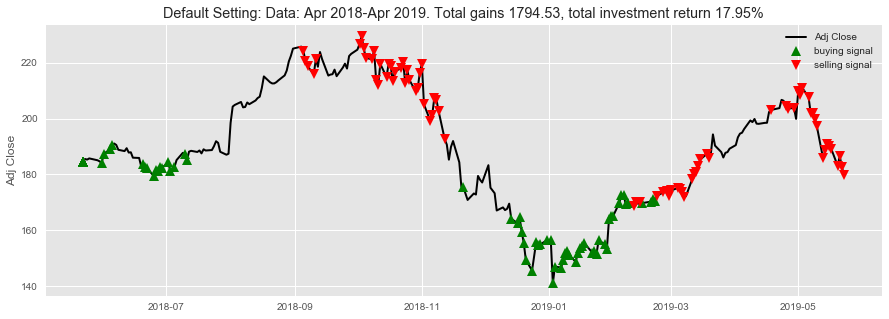

In [26]:
close = X_test['Adj Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='k', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('Default Setting: Data: Apr 2018-Apr 2019. Total gains %.2f, total investment return %.2f%%'%(total_gains, invest))

plt.ylabel('Adj Close')
plt.legend()
filename = prefix +'_default_setting_ROI.png'
plt.savefig(filename)
#plt.show()


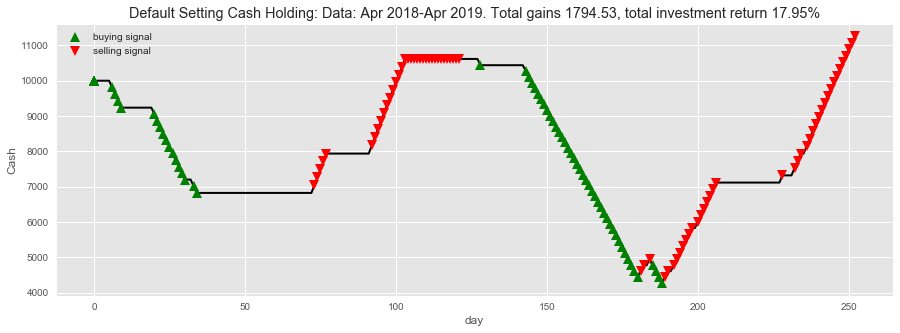

In [27]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='k', lw=2.)
plt.plot(states_money, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.ylabel('Cash')
plt.xlabel('day')
plt.title('Default Setting Cash Holding: Data: Apr 2018-Apr 2019. Total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
filename = prefix +'_default_setting_Cash_vs_day.png'
plt.savefig(filename)
#plt.show()

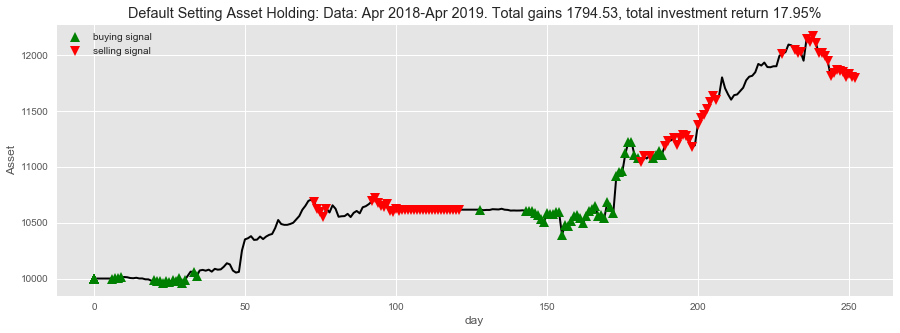

In [28]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_asset, color='k', lw=2.)
plt.plot(states_asset, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_asset, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.ylabel('Asset')
plt.xlabel('day')
plt.title('Default Setting Asset Holding: Data: Apr 2018-Apr 2019. Total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
filename = prefix +'_default_setting_Asset_vs_day.png'
plt.savefig(filename)

In [29]:
states_buy_default_testing, states_sell_default_testing, total_gains_default_testing, invest_default_testing, states_money_default_testing, states_asset_default_testing = \
states_buy, states_sell, total_gains, invest, states_money, states_asset

## Default Setting Performance for training data
**using previous one year data for training **

In [30]:
best_param=  [4, 7, 1, 1]

In [31]:
skip_loop, ma, max_buy, max_sell = best_param
signal = abcd(X_train['Adj Close'], skip_loop = skip_loop, ma = ma)
states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_train['Adj Close'], signal,max_buy, max_sell)



day 6: buy 1 units at price 148.166336, total balance 9851.833664
day 7: buy 1 units at price 148.573685, total balance 9703.259979
day 8: buy 1 units at price 150.775436, total balance 9552.484543
day 9: buy 1 units at price 149.301117, total balance 9403.183426
day 12: buy 1 units at price 150.329269, total balance 9252.854156
day 13: buy 1 units at price 144.500000, total balance 9108.354156
day 14: buy 1 units at price 141.047043, total balance 8967.307114
day 15: buy 1 units at price 142.181839, total balance 8825.125275
day 16: buy 1 units at price 140.794876, total balance 8684.330399
day 17: buy 1 units at price 139.951019, total balance 8544.379379
day 18: buy 1 units at price 137.991791, total balance 8406.387589
day 19: buy 1 units at price 141.939392, total balance 8264.448196
day 20: buy 1 units at price 140.649384, total balance 8123.798813
day 21: buy 1 units at price 141.483521, total balance 7982.315292
day 22: buy 1 units at price 141.250763, total balance 7841.064529

In [32]:
close = X_train['Adj Close']



In [33]:
X_train.describe()

,High,Low,Open,Close,Volume,Adj Close
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000
mean,166.052756,163.400985,164.725630,164.749291,3.034867e+07,160.837324
std,11.567923,11.459870,11.413267,11.515264,1.258306e+07,11.859947
min,143.500000,142.199997,142.899994,142.270004,1.402670e+07,137.991791
25%,157.004997,154.499996,155.849998,155.480000,2.157180e+07,151.386440
50%,167.454994,163.904999,165.599998,165.489998,2.670500e+07,162.249199
75%,175.044998,172.660004,173.677494,174.127499,3.542170e+07,170.098068
max,190.369995,187.860001,189.490005,190.039993,8.659380e+07,186.471527


In [34]:
date = X_train.index

best_param= [4, 7, 1, 1]


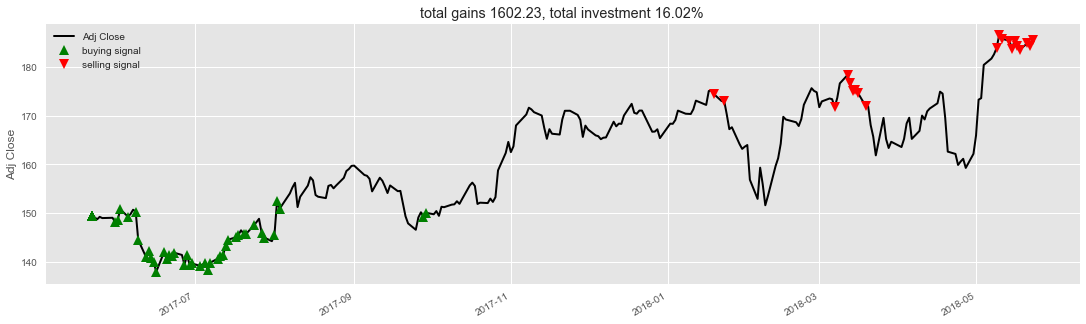

In [35]:
fig = plt.figure(figsize = (15,5))
plt.plot(date,close, color='k', lw=2.)
plt.plot(date,close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(date,close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('total gains %.2f, total investment %.2f%%'%(total_gains, invest))

plt.xticks(rotation=90)
plt.tight_layout()
fig.autofmt_xdate()
plt.legend()
plt.ylabel('Adj Close')
#plt.show()
filename = prefix + 'Default_setting_training_ROI.png'
plt.savefig(filename)
print('best_param=',best_param)

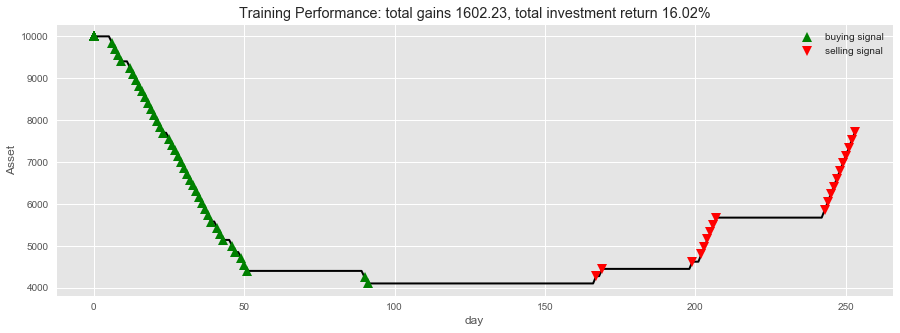

In [36]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='k', lw=2.)
plt.plot(states_money, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Training Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Asset')
filename = prefix + 'Default_setting_training_Cash.png'
#plt.show()
plt.savefig(filename)

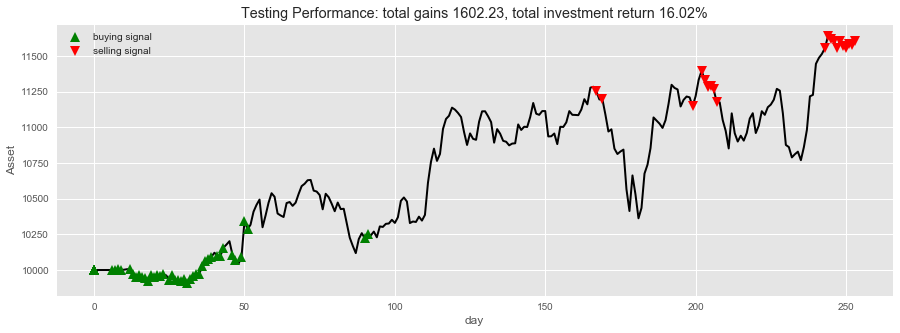

In [37]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_asset, color='k', lw=2.)
plt.plot(states_asset, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_asset, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Testing Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Asset')
#plt.show()
filename = prefix + 'Default_setting_training_Asset.png'
plt.savefig(filename)

In [38]:
states_buy_default_training, states_sell_default_training, total_gains_default_training, invest_default_training, states_money_default_training, states_asset_default_training = \
states_buy, states_sell, total_gains, invest, states_money, states_asset

sharpe_ratio_train = get_sharpe_ratio(X_train, states_asset_default_training)
sharpe_ratio_test = get_sharpe_ratio(X_test, states_asset_default_testing)

sharpe_ratios = '''sharpe_ratio_train ={0:.2f}%, sharpe_ratio_test ={1:.2f}%'''
print(sharpe_ratios.format(sharpe_ratio_train*100,sharpe_ratio_test*100))

In [39]:
sharpe_ratio_default_setting_train = get_sharpe_ratio_from_bankrate(states_asset_default_training)
sharpe_ratio_buy_and_hold_train = get_sharpe_ratio_from_bankrate(X_train)
sharpe_ratios = '''sharpe_ratio_default_setting_train ={0:.2f}%, sharpe_ratio_buy_and_hold_train ={1:.2f}%'''
print(sharpe_ratios.format(sharpe_ratio_default_setting_train*100,sharpe_ratio_buy_and_hold_train*100))

sharpe_ratio_default_setting_train =707.53%, sharpe_ratio_buy_and_hold_train =635.74%


In [40]:
bank_rate = 0.025
asset = states_asset_default_training
asset_array = np.asarray(asset)
days = asset_array.size    
benchmark_ret = bank_rate/days
asset_ret = get_return(asset_array)
excess_ret =(asset_ret-benchmark_ret)
sharpe_ratio = np.mean(excess_ret)/np.std(excess_ret)

avg_ret = np.mean(excess_ret)
## Take all negative returns
neg_ret = [a**2 for a in excess_ret if a<0]
# Sum it
neg_ret_sum = np.sum(neg_ret)
# Calculate downside risk 
down_risk = np.sqrt(neg_ret_sum /excess_ret.size) 
if down_risk > 0.0001:
    sortino = avg_ret / down_risk
else:
    sortino = 0
#return sortino

In [41]:
days

254

In [42]:
sortino_ratio_default_setting_train = get_sortino_from_bankrate(states_asset_default_training)
sortino_ratio_buy_and_hold_train = get_sortino_from_bankrate(X_train['Adj Close'])
sortino_ratios = '''sortino_ratio_default_setting_train ={0:.2f}%, sortino_ratio_buy_and_hold_train ={1:.2f}%'''
print(sortino_ratios.format(sortino_ratio_default_setting_train*100,sortino_ratio_buy_and_hold_train*100))


sortino_ratio_default_setting_train =1088.22%, sortino_ratio_buy_and_hold_train =936.52%


In [43]:
sortino_ratio_default_setting_train

10.882235643602232

## Optimize Hyper parameters by GA to get the best_param


### Generate next generation of parameter sets

In [44]:
def gen_list(best_param):
    skip_loop, ma, max_buy, max_sell = best_param
    gap = randint(1,10)
    if (skip_loop -gap)>0 and ma-gap> 0 and max_buy-5*gap>0:
        skip_loop_list = [skip_loop-gap, skip_loop, skip_loop+gap]
        ma_list =[ma-gap, ma, ma+gap]
        max_list = [max_buy-5*gap, max_buy, max_buy+5*gap]
    else: 
        skip_loop_list = [skip_loop, skip_loop+gap, skip_loop+2*gap ]
        ma_list =[ma, ma+gap, ma+2*gap]
        max_list = [max_buy, max_buy+5*gap, max_buy+10*gap]
    return skip_loop_list, ma_list, max_list, max_list



### GA Optimization of Hyper Parameters

day 2: buy 10 units at price 1487.288818, total balance 8512.711182
day 3: buy 10 units at price 1492.429504, total balance 7020.281677
day 4: buy 10 units at price 1489.907684, total balance 5530.373993
day 5: buy 10 units at price 1490.489655, total balance 4039.884338
day 6: buy 10 units at price 1481.663361, total balance 2558.220978
day 7: buy 10 units at price 1485.736847, total balance 1072.484131
day 8: buy 7 units at price 1055.428055, total balance 17.056076
day 13: total balances 17.056076, not enough money to buy a unit price 144.500000
day 14: total balances 17.056076, not enough money to buy a unit price 141.047043
day 15: total balances 17.056076, not enough money to buy a unit price 142.181839
day 16: total balances 17.056076, not enough money to buy a unit price 140.794876
day 17: total balances 17.056076, not enough money to buy a unit price 139.951019
day 18: total balances 17.056076, not enough money to buy a unit price 137.991791
day 19: total balances 17.056076, n

day 2: buy 67 units at price 9964.835083, total balance 35.164917
day 3: total balances 35.164917, not enough money to buy a unit price 149.242950
day 4: total balances 35.164917, not enough money to buy a unit price 148.990768
day 5: total balances 35.164917, not enough money to buy a unit price 149.048965
day 6: total balances 35.164917, not enough money to buy a unit price 148.166336
day 7: total balances 35.164917, not enough money to buy a unit price 148.573685
day 8: total balances 35.164917, not enough money to buy a unit price 150.775436
day 13: total balances 35.164917, not enough money to buy a unit price 144.500000
day 14: total balances 35.164917, not enough money to buy a unit price 141.047043
day 15: total balances 35.164917, not enough money to buy a unit price 142.181839
day 16: total balances 35.164917, not enough money to buy a unit price 140.794876
day 17: total balances 35.164917, not enough money to buy a unit price 139.951019
day 18: total balances 35.164917, not 

day 6: buy 67 units at price 9927.144516, total balance 72.855484
day 7: total balances 72.855484, not enough money to buy a unit price 148.573685
day 8: total balances 72.855484, not enough money to buy a unit price 150.775436
day 9: total balances 72.855484, not enough money to buy a unit price 149.301117
day 14: total balances 72.855484, not enough money to buy a unit price 141.047043
day 15: total balances 72.855484, not enough money to buy a unit price 142.181839
day 16: total balances 72.855484, not enough money to buy a unit price 140.794876
day 17: total balances 72.855484, not enough money to buy a unit price 139.951019
day 18: total balances 72.855484, not enough money to buy a unit price 137.991791
day 19: total balances 72.855484, not enough money to buy a unit price 141.939392
day 20: total balances 72.855484, not enough money to buy a unit price 140.649384
day 21: total balances 72.855484, not enough money to buy a unit price 141.483521
day 22: total balances 72.855484, n

day 12: buy 50 units at price 7516.463470, total balance 2483.536530
day 13: buy 17 units at price 2456.500000, total balance 27.036530
day 14: total balances 27.036530, not enough money to buy a unit price 141.047043
day 15: total balances 27.036530, not enough money to buy a unit price 142.181839
day 16: total balances 27.036530, not enough money to buy a unit price 140.794876
day 17: total balances 27.036530, not enough money to buy a unit price 139.951019
day 18: total balances 27.036530, not enough money to buy a unit price 137.991791
day 19: total balances 27.036530, not enough money to buy a unit price 141.939392
day 20: total balances 27.036530, not enough money to buy a unit price 140.649384
day 21: total balances 27.036530, not enough money to buy a unit price 141.483521
day 22: total balances 27.036530, not enough money to buy a unit price 141.250763
day 23: total balances 27.036530, not enough money to buy a unit price 141.881210
day 24: total balances 27.036530, not enough

day 12: buy 66 units at price 9921.731781, total balance 78.268219
day 13: total balances 78.268219, not enough money to buy a unit price 144.500000
day 14: total balances 78.268219, not enough money to buy a unit price 141.047043
day 15: total balances 78.268219, not enough money to buy a unit price 142.181839
day 16: total balances 78.268219, not enough money to buy a unit price 140.794876
day 17: total balances 78.268219, not enough money to buy a unit price 139.951019
day 18: total balances 78.268219, not enough money to buy a unit price 137.991791
day 19: total balances 78.268219, not enough money to buy a unit price 141.939392
day 20: total balances 78.268219, not enough money to buy a unit price 140.649384
day 21: total balances 78.268219, not enough money to buy a unit price 141.483521
day 22: total balances 78.268219, not enough money to buy a unit price 141.250763
day 23: total balances 78.268219, not enough money to buy a unit price 141.881210
day 24: total balances 78.26821

day 2: buy 50 units at price 7436.444092, total balance 2563.555908
day 3: buy 17 units at price 2537.130157, total balance 26.425751
day 4: total balances 26.425751, not enough money to buy a unit price 148.990768
day 5: total balances 26.425751, not enough money to buy a unit price 149.048965
day 6: total balances 26.425751, not enough money to buy a unit price 148.166336
day 7: total balances 26.425751, not enough money to buy a unit price 148.573685
day 8: total balances 26.425751, not enough money to buy a unit price 150.775436
day 9: total balances 26.425751, not enough money to buy a unit price 149.301117
day 13: total balances 26.425751, not enough money to buy a unit price 144.500000
day 14: total balances 26.425751, not enough money to buy a unit price 141.047043
day 15: total balances 26.425751, not enough money to buy a unit price 142.181839
day 16: total balances 26.425751, not enough money to buy a unit price 140.794876
day 17: total balances 26.425751, not enough money t

day 2: buy 67 units at price 9964.835083, total balance 35.164917
day 3: total balances 35.164917, not enough money to buy a unit price 149.242950
day 4: total balances 35.164917, not enough money to buy a unit price 148.990768
day 5: total balances 35.164917, not enough money to buy a unit price 149.048965
day 6: total balances 35.164917, not enough money to buy a unit price 148.166336
day 7: total balances 35.164917, not enough money to buy a unit price 148.573685
day 8: total balances 35.164917, not enough money to buy a unit price 150.775436
day 9: total balances 35.164917, not enough money to buy a unit price 149.301117
day 13: total balances 35.164917, not enough money to buy a unit price 144.500000
day 14: total balances 35.164917, not enough money to buy a unit price 141.047043
day 15: total balances 35.164917, not enough money to buy a unit price 142.181839
day 16: total balances 35.164917, not enough money to buy a unit price 140.794876
day 17: total balances 35.164917, not e

day 6: buy 50 units at price 7408.316803, total balance 2591.683197
day 7: buy 17 units at price 2525.752640, total balance 65.930557
day 8: total balances 65.930557, not enough money to buy a unit price 150.775436
day 9: total balances 65.930557, not enough money to buy a unit price 149.301117
day 10: total balances 65.930557, not enough money to buy a unit price 149.805511
day 11: total balances 65.930557, not enough money to buy a unit price 150.697861
day 14: total balances 65.930557, not enough money to buy a unit price 141.047043
day 15: total balances 65.930557, not enough money to buy a unit price 142.181839
day 16: total balances 65.930557, not enough money to buy a unit price 140.794876
day 17: total balances 65.930557, not enough money to buy a unit price 139.951019
day 18: total balances 65.930557, not enough money to buy a unit price 137.991791
day 19: total balances 65.930557, not enough money to buy a unit price 141.939392
day 20: total balances 65.930557, not enough mon

day 6: buy 67 units at price 9927.144516, total balance 72.855484
day 7: total balances 72.855484, not enough money to buy a unit price 148.573685
day 8: total balances 72.855484, not enough money to buy a unit price 150.775436
day 9: total balances 72.855484, not enough money to buy a unit price 149.301117
day 10: total balances 72.855484, not enough money to buy a unit price 149.805511
day 11: total balances 72.855484, not enough money to buy a unit price 150.697861
day 14: total balances 72.855484, not enough money to buy a unit price 141.047043
day 15: total balances 72.855484, not enough money to buy a unit price 142.181839
day 16: total balances 72.855484, not enough money to buy a unit price 140.794876
day 17: total balances 72.855484, not enough money to buy a unit price 139.951019
day 18: total balances 72.855484, not enough money to buy a unit price 137.991791
day 19: total balances 72.855484, not enough money to buy a unit price 141.939392
day 20: total balances 72.855484, n

day 12: buy 50 units at price 7516.463470, total balance 2483.536530
day 13: buy 17 units at price 2456.500000, total balance 27.036530
day 14: total balances 27.036530, not enough money to buy a unit price 141.047043
day 15: total balances 27.036530, not enough money to buy a unit price 142.181839
day 16: total balances 27.036530, not enough money to buy a unit price 140.794876
day 17: total balances 27.036530, not enough money to buy a unit price 139.951019
day 18: total balances 27.036530, not enough money to buy a unit price 137.991791
day 19: total balances 27.036530, not enough money to buy a unit price 141.939392
day 20: total balances 27.036530, not enough money to buy a unit price 140.649384
day 21: total balances 27.036530, not enough money to buy a unit price 141.483521
day 22: total balances 27.036530, not enough money to buy a unit price 141.250763
day 23: total balances 27.036530, not enough money to buy a unit price 141.881210
day 24: total balances 27.036530, not enough

day 12: buy 66 units at price 9921.731781, total balance 78.268219
day 13: total balances 78.268219, not enough money to buy a unit price 144.500000
day 14: total balances 78.268219, not enough money to buy a unit price 141.047043
day 15: total balances 78.268219, not enough money to buy a unit price 142.181839
day 16: total balances 78.268219, not enough money to buy a unit price 140.794876
day 17: total balances 78.268219, not enough money to buy a unit price 139.951019
day 18: total balances 78.268219, not enough money to buy a unit price 137.991791
day 19: total balances 78.268219, not enough money to buy a unit price 141.939392
day 20: total balances 78.268219, not enough money to buy a unit price 140.649384
day 21: total balances 78.268219, not enough money to buy a unit price 141.483521
day 22: total balances 78.268219, not enough money to buy a unit price 141.250763
day 23: total balances 78.268219, not enough money to buy a unit price 141.881210
day 24: total balances 78.26821

day 2: buy 50 units at price 7436.444092, total balance 2563.555908
day 3: buy 17 units at price 2537.130157, total balance 26.425751
day 4: total balances 26.425751, not enough money to buy a unit price 148.990768
day 5: total balances 26.425751, not enough money to buy a unit price 149.048965
day 6: total balances 26.425751, not enough money to buy a unit price 148.166336
day 7: total balances 26.425751, not enough money to buy a unit price 148.573685
day 8: total balances 26.425751, not enough money to buy a unit price 150.775436
day 9: total balances 26.425751, not enough money to buy a unit price 149.301117
day 11: total balances 26.425751, not enough money to buy a unit price 150.697861
day 12: total balances 26.425751, not enough money to buy a unit price 150.329269
day 13: total balances 26.425751, not enough money to buy a unit price 144.500000
day 14: total balances 26.425751, not enough money to buy a unit price 141.047043
day 15: total balances 26.425751, not enough money t

day 2: buy 67 units at price 9964.835083, total balance 35.164917
day 3: total balances 35.164917, not enough money to buy a unit price 149.242950
day 4: total balances 35.164917, not enough money to buy a unit price 148.990768
day 5: total balances 35.164917, not enough money to buy a unit price 149.048965
day 6: total balances 35.164917, not enough money to buy a unit price 148.166336
day 7: total balances 35.164917, not enough money to buy a unit price 148.573685
day 8: total balances 35.164917, not enough money to buy a unit price 150.775436
day 9: total balances 35.164917, not enough money to buy a unit price 149.301117
day 11: total balances 35.164917, not enough money to buy a unit price 150.697861
day 12: total balances 35.164917, not enough money to buy a unit price 150.329269
day 13: total balances 35.164917, not enough money to buy a unit price 144.500000
day 14: total balances 35.164917, not enough money to buy a unit price 141.047043
day 15: total balances 35.164917, not e

day 6: buy 50 units at price 7408.316803, total balance 2591.683197
day 7: buy 17 units at price 2525.752640, total balance 65.930557
day 8: total balances 65.930557, not enough money to buy a unit price 150.775436
day 9: total balances 65.930557, not enough money to buy a unit price 149.301117
day 10: total balances 65.930557, not enough money to buy a unit price 149.805511
day 11: total balances 65.930557, not enough money to buy a unit price 150.697861
day 12: total balances 65.930557, not enough money to buy a unit price 150.329269
day 13: total balances 65.930557, not enough money to buy a unit price 144.500000
day 14: total balances 65.930557, not enough money to buy a unit price 141.047043
day 15: total balances 65.930557, not enough money to buy a unit price 142.181839
day 16: total balances 65.930557, not enough money to buy a unit price 140.794876
day 17: total balances 65.930557, not enough money to buy a unit price 139.951019
day 18: total balances 65.930557, not enough mon

day 6: buy 67 units at price 9927.144516, total balance 72.855484
day 7: total balances 72.855484, not enough money to buy a unit price 148.573685
day 8: total balances 72.855484, not enough money to buy a unit price 150.775436
day 9: total balances 72.855484, not enough money to buy a unit price 149.301117
day 10: total balances 72.855484, not enough money to buy a unit price 149.805511
day 11: total balances 72.855484, not enough money to buy a unit price 150.697861
day 12: total balances 72.855484, not enough money to buy a unit price 150.329269
day 13: total balances 72.855484, not enough money to buy a unit price 144.500000
day 14: total balances 72.855484, not enough money to buy a unit price 141.047043
day 15: total balances 72.855484, not enough money to buy a unit price 142.181839
day 16: total balances 72.855484, not enough money to buy a unit price 140.794876
day 17: total balances 72.855484, not enough money to buy a unit price 139.951019
day 18: total balances 72.855484, n

day 12: buy 50 units at price 7516.463470, total balance 2483.536530
day 13: buy 17 units at price 2456.500000, total balance 27.036530
day 14: total balances 27.036530, not enough money to buy a unit price 141.047043
day 15: total balances 27.036530, not enough money to buy a unit price 142.181839
day 16: total balances 27.036530, not enough money to buy a unit price 140.794876
day 17: total balances 27.036530, not enough money to buy a unit price 139.951019
day 18: total balances 27.036530, not enough money to buy a unit price 137.991791
day 19: total balances 27.036530, not enough money to buy a unit price 141.939392
day 20: total balances 27.036530, not enough money to buy a unit price 140.649384
day 21: total balances 27.036530, not enough money to buy a unit price 141.483521
day 22: total balances 27.036530, not enough money to buy a unit price 141.250763
day 23: total balances 27.036530, not enough money to buy a unit price 141.881210
day 24: total balances 27.036530, not enough

day 12: buy 66 units at price 9921.731781, total balance 78.268219
day 13: total balances 78.268219, not enough money to buy a unit price 144.500000
day 14: total balances 78.268219, not enough money to buy a unit price 141.047043
day 15: total balances 78.268219, not enough money to buy a unit price 142.181839
day 16: total balances 78.268219, not enough money to buy a unit price 140.794876
day 17: total balances 78.268219, not enough money to buy a unit price 139.951019
day 18: total balances 78.268219, not enough money to buy a unit price 137.991791
day 19: total balances 78.268219, not enough money to buy a unit price 141.939392
day 20: total balances 78.268219, not enough money to buy a unit price 140.649384
day 21: total balances 78.268219, not enough money to buy a unit price 141.483521
day 22: total balances 78.268219, not enough money to buy a unit price 141.250763
day 23: total balances 78.268219, not enough money to buy a unit price 141.881210
day 24: total balances 78.26821

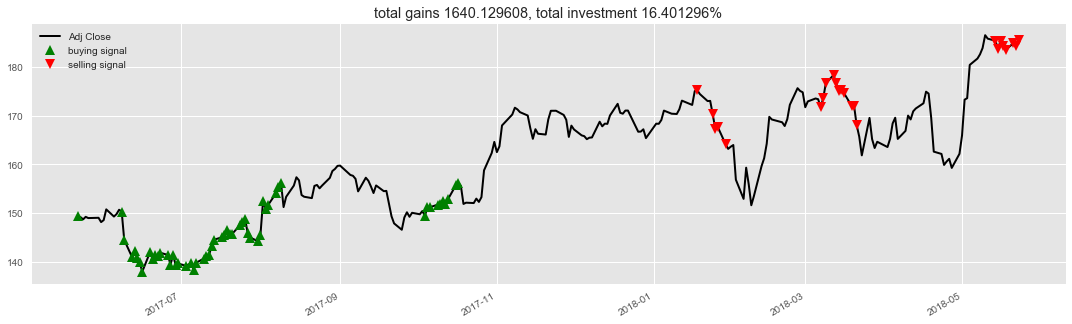

total gains 1640.129608, total investment 16.401296%
best_param= [3, 13, 10, 10]


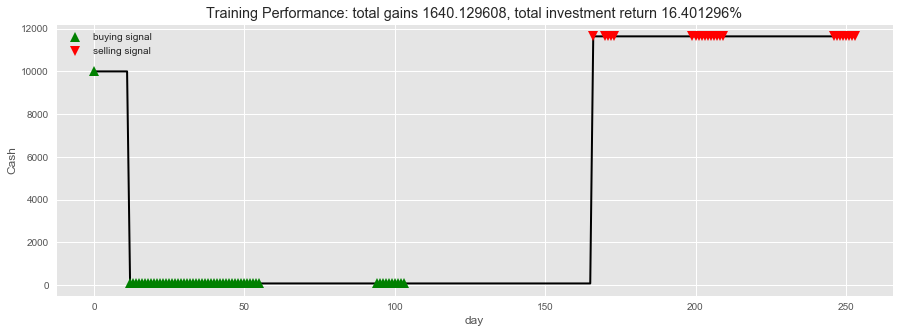

In [45]:
best_J =[]
i=0
J=[]
param_vec = []

for iter in np.arange(1):
    if iter == 0:
        skip_loop_list = [3,  5,  7]
        ma_list = [3,  7,  13]
        max_list = [10, 50,  100,250]
        best_param =[]
        for skip_loop in skip_loop_list:
            for ma in ma_list:
                for max_buy, max_sell in zip (max_list, max_list):
                    signal = abcd(X_train['Adj Close'], skip_loop = skip_loop, ma = ma)
                    states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_train['Adj Close'], signal,max_buy, max_sell)
                    J.append(invest)
                    param =[skip_loop, ma, max_buy, max_sell]
                    param_vec.append(param)
                    best_J.append(max(J))
                    i=i+1
        maxpos = J.index(max(J))
        best_param = param_vec[maxpos]
    else:
        skip_loop, ma, max_buy, max_sell = gen_list(best_param)
        for skip_loop in skip_loop_list:
            for ma in ma_list: 
                for max_buy, max_sell in zip (max_list, max_list):
                    signal = abcd(X_train['Adj Close'], skip_loop = skip_loop, ma = ma)
                    states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_train['Adj Close'], signal,max_buy, max_sell)
                    J.append(invest)
                    param =[skip_loop, ma, max_buy, max_sell]
                    param_vec.append(param)
                    best_J.append(max(J))
                    i=i+1
        maxpos = J.index(max(J))
        best_param = param_vec[maxpos]
    
    print('----------------iter =',iter,'---------------------------------------')
    print('iter=', iter,' best_J=',max(J), 'best_param =', best_param)
    print('param=', param)
    print('param_vec=',param_vec)
    print('J=',J)
    
    close = X_train['Adj Close']
    date = X_train.index
    fig = plt.figure(figsize = (15,5))
    plt.plot(date,close, color='k', lw=2.)
    plt.plot(date,close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
    plt.plot(date,close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.xticks(rotation=90)
    plt.tight_layout()
    fig.autofmt_xdate()
    plt.legend()
    plt.show()
    print('total gains %f, total investment %f%%'%(total_gains, invest))
    print('best_param=',best_param)
    
    fig = plt.figure(figsize = (15,5))
    plt.plot(states_money, color='k', lw=2.)
    plt.plot(states_money, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
    plt.plot(states_money, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
    plt.legend()
    plt.title('Training Performance: total gains %f, total investment return %f%%'%(total_gains, invest))
    plt.xlabel('day')
    plt.ylabel('Cash')


    

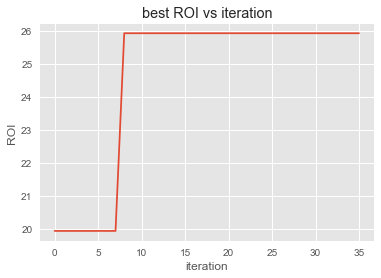

In [46]:
plt.plot(best_J)
plt.xlabel('iteration')
plt.ylabel('ROI')
best_param
plt.title('best ROI vs iteration')
filename = prefix + 'best_ROI_vs_iter.png'
plt.savefig(filename)

In [47]:
J

[19.939762420654297,
 17.964255828857421,
 17.45114044189453,
 17.45114044189453,
 19.290169067382813,
 16.614835662841799,
 16.619242858886718,
 16.619242858886718,
 25.918875122070311,
 18.330871734619141,
 17.332502746582033,
 17.332502746582033,
 16.967111663818361,
 17.556490173339846,
 17.617301177978515,
 17.617301177978515,
 15.682597198486329,
 17.654264526367189,
 18.098965911865232,
 18.098965911865232,
 23.177326965332032,
 18.882892608642578,
 17.338958129882812,
 17.338958129882812,
 16.49021957397461,
 17.501767883300783,
 17.722060241699218,
 17.722060241699218,
 15.206148681640624,
 15.592584075927734,
 15.316282196044922,
 15.316282196044922,
 19.295750427246094,
 16.803479156494141,
 16.401296081542966,
 16.401296081542966]

In [48]:
param_vec

[[3, 3, 10, 10],
 [3, 3, 50, 50],
 [3, 3, 100, 100],
 [3, 3, 250, 250],
 [3, 7, 10, 10],
 [3, 7, 50, 50],
 [3, 7, 100, 100],
 [3, 7, 250, 250],
 [3, 13, 10, 10],
 [3, 13, 50, 50],
 [3, 13, 100, 100],
 [3, 13, 250, 250],
 [5, 3, 10, 10],
 [5, 3, 50, 50],
 [5, 3, 100, 100],
 [5, 3, 250, 250],
 [5, 7, 10, 10],
 [5, 7, 50, 50],
 [5, 7, 100, 100],
 [5, 7, 250, 250],
 [5, 13, 10, 10],
 [5, 13, 50, 50],
 [5, 13, 100, 100],
 [5, 13, 250, 250],
 [7, 3, 10, 10],
 [7, 3, 50, 50],
 [7, 3, 100, 100],
 [7, 3, 250, 250],
 [7, 7, 10, 10],
 [7, 7, 50, 50],
 [7, 7, 100, 100],
 [7, 7, 250, 250],
 [7, 13, 10, 10],
 [7, 13, 50, 50],
 [7, 13, 100, 100],
 [7, 13, 250, 250]]

In [49]:
best_J

[19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 19.939762420654297,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311,
 25.918875122070311]

In [50]:
best_param

[3, 13, 10, 10]

In [51]:
maxpos = J.index(max(J))
best_param2 = param_vec[maxpos]

In [52]:
best_param2

[3, 13, 10, 10]

## Training performance with optimized Hyper Parameters

In [53]:
skip_loop, ma, max_buy, max_sell = best_param
signal = abcd(X_train['Adj Close'], skip_loop = skip_loop, ma = ma)
states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_train['Adj Close'], signal,max_buy, max_sell)



day 12: buy 10 units at price 1503.292694, total balance 8496.707306
day 13: buy 10 units at price 1445.000000, total balance 7051.707306
day 14: buy 10 units at price 1410.470428, total balance 5641.236877
day 15: buy 10 units at price 1421.818390, total balance 4219.418488
day 16: buy 10 units at price 1407.948761, total balance 2811.469727
day 17: buy 10 units at price 1399.510193, total balance 1411.959534
day 18: buy 10 units at price 1379.917908, total balance 32.041626
day 19: total balances 32.041626, not enough money to buy a unit price 141.939392
day 20: total balances 32.041626, not enough money to buy a unit price 140.649384
day 21: total balances 32.041626, not enough money to buy a unit price 141.483521
day 22: total balances 32.041626, not enough money to buy a unit price 141.250763
day 23: total balances 32.041626, not enough money to buy a unit price 141.881210
day 24: total balances 32.041626, not enough money to buy a unit price 141.435043
day 25: total balances 32.0

total gains 2591.887512, total investment return 25.918875%
best_param= [3, 13, 10, 10]


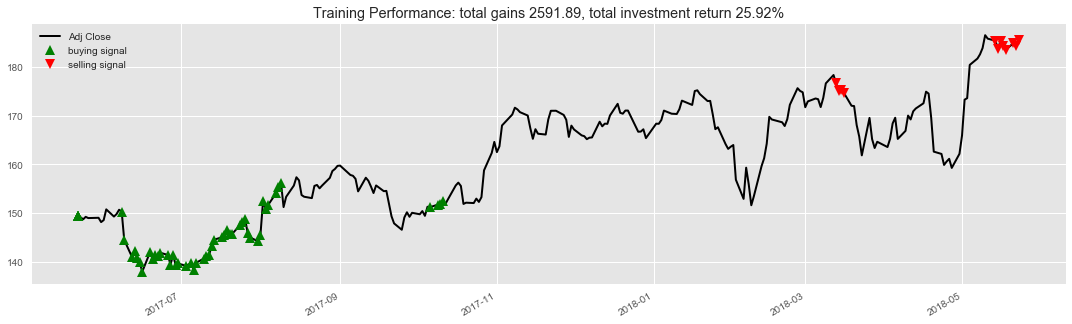

In [54]:
close = X_train['Adj Close']
date = X_train.index
fig = plt.figure(figsize = (15,5))
plt.plot(date,close, color='k', lw=2.)
plt.plot(date,close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(date,close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
#plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.title('Training Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xticks(rotation=90)
plt.tight_layout()
fig.autofmt_xdate()
plt.legend()
#plt.show()
print('total gains %f, total investment return %f%%'%(total_gains, invest))

print('best_param=',best_param)
filename = prefix + 'Training_Performance_ROI.png'
plt.savefig(filename)

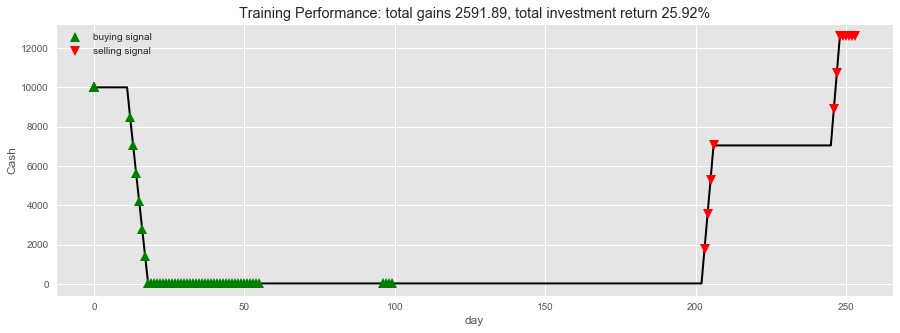

In [55]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='k', lw=2.)
plt.plot(states_money, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Training Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Cash')
filename = prefix + 'Training_Performance_Cash.png'
#plt.show()
plt.savefig(filename)

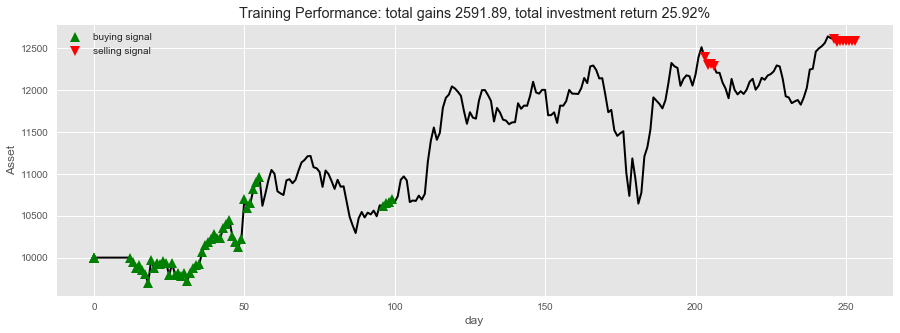

In [56]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_asset, color='k', lw=2.)
plt.plot(states_asset, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_asset, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Training Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Asset')

#plt.show()
filename = prefix + '_Training_Performance_Asset.png'
plt.savefig(filename)

In [57]:

states_buy_optimal_training, states_sell_optimal_training, total_gains_optimal_training, invest_optimal_training, states_money_optimal_training, states_asset_optimal_training = \
states_buy, states_sell, total_gains, invest, states_money, states_asset


In [58]:
pd_states_asset_optimal_training=pd.DataFrame(states_asset_optimal_training, columns=['AssetValue'], index=X_train.index) 
file_name_opt_train = 'dataset/'+Stock+'_opt_train.csv'
pd_states_asset_optimal_training.to_csv(file_name_opt_train, sep=',', encoding='utf-8')

In [59]:
sharpe_ratio_optimal_setting_train = get_sharpe_ratio_from_bankrate(states_asset_optimal_training)
sharpe_ratio_buy_and_hold_train = get_sharpe_ratio_from_bankrate(X_train)
sharpe_ratios = '''sharpe_ratio_default_setting_train ={0:.2f}%, sharpe_ratio_buy_and_hold_train ={1:.2f}%'''
print(sharpe_ratios.format(sharpe_ratio_optimal_setting_train*100,sharpe_ratio_buy_and_hold_train*100))

sharpe_ratio_default_setting_train =765.66%, sharpe_ratio_buy_and_hold_train =635.74%


In [60]:
sortino_ratio_optimal_setting_train = get_sortino_from_bankrate(states_asset_optimal_training)
sortino_ratio_buy_and_hold_train = get_sortino_from_bankrate(X_train['Adj Close'])
sortino_ratios = '''sortino_ratio_optimal_setting_train ={0:.2f}%, sortino_ratio_buy_and_hold_train ={1:.2f}%'''
print(sortino_ratios.format(sortino_ratio_optimal_setting_train*100,sortino_ratio_buy_and_hold_train*100))



sortino_ratio_optimal_setting_train =1194.41%, sortino_ratio_buy_and_hold_train =936.52%


## Test Performance with optimized Hyper Parameters
**using current one year data**

In [61]:
skip_loop, ma, max_buy, max_sell = best_param
signal = abcd(X_test['Adj Close'], skip_loop = skip_loop, ma = ma)
states_buy, states_sell, total_gains, invest, states_money, states_asset = buy_stock(X_test['Adj Close'], signal,max_buy, max_sell)




day 12: buy 10 units at price 1888.256989, total balance 8111.743011
day 13: buy 10 units at price 1883.627472, total balance 6228.115540
day 14: buy 10 units at price 1893.970032, total balance 4334.145508
day 20: buy 10 units at price 1837.036591, total balance 2497.108917
day 22: buy 10 units at price 1821.473541, total balance 675.635376
day 23: buy 3 units at price 538.315750, total balance 137.319626
day 24: total balances 137.319626, not enough money to buy a unit price 181.664673
day 25: total balances 137.319626, not enough money to buy a unit price 181.398743
day 26: total balances 137.319626, not enough money to buy a unit price 182.718643
day 27: total balances 137.319626, not enough money to buy a unit price 182.334488
day 28: total balances 137.319626, not enough money to buy a unit price 184.373459
day 29: total balances 137.319626, not enough money to buy a unit price 181.162354
day 30: total balances 137.319626, not enough money to buy a unit price 182.620163
day 31: t

total gains 3059.605301, total investment 30.596053%
best_param= [3, 13, 10, 10]


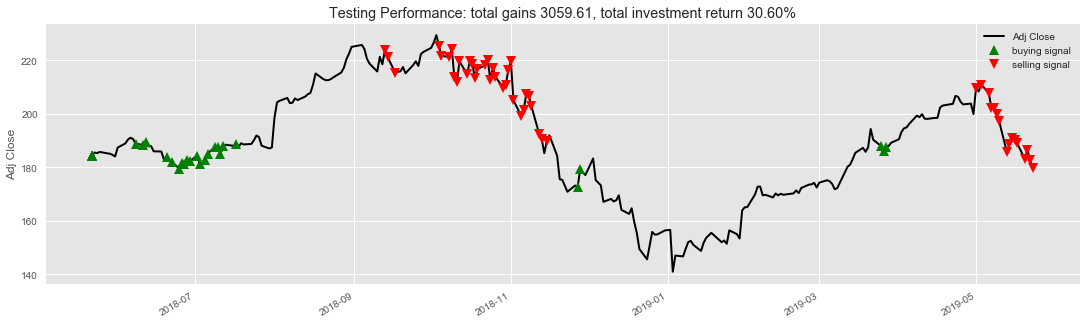

In [62]:
close = X_test['Adj Close']
date = X_test.index
fig = plt.figure(figsize = (15,5))
plt.plot(date,close, color='k', lw=2.)
plt.plot(date,close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(date,close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
#plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.title('Testing Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))

plt.xticks(rotation=90)
plt.tight_layout()
fig.autofmt_xdate()
plt.ylabel('Adj Close')
plt.legend()
#plt.show()
print('total gains %f, total investment %f%%'%(total_gains, invest))
print('best_param=',best_param)
filename = prefix + '_Testing_Performance_ROI.png'
plt.savefig(filename)

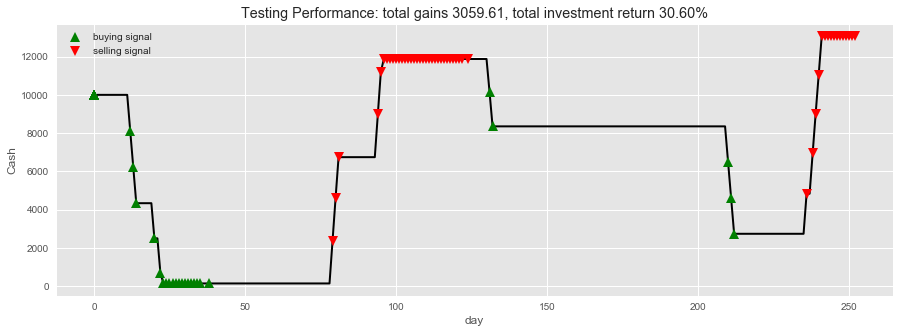

In [63]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='k', lw=2.)
plt.plot(states_money, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Testing Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Cash')
filename = prefix + 'Testing_Performance_Cash.png'
#plt.show()
plt.savefig(filename)

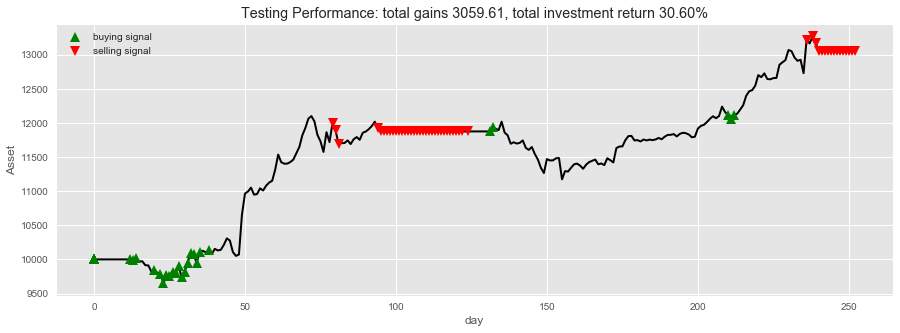

In [64]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_asset, color='k', lw=2.)
plt.plot(states_asset, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(states_asset, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.title('Testing Performance: total gains %.2f, total investment return %.2f%%'%(total_gains, invest))
plt.xlabel('day')
plt.ylabel('Asset')
#plt.show()
filename = prefix + '_Testing_Performance_Asset.png'
plt.savefig(filename)

In [65]:
states_buy_optimal_testing, states_sell_optimal_testing, total_gains_optimal_testing, invest_optimal_testing, states_money_optimal_testing, states_asset_optimal_testing = \
states_buy, states_sell, total_gains, invest, states_money, states_asset

## Compare cash holding for testing data

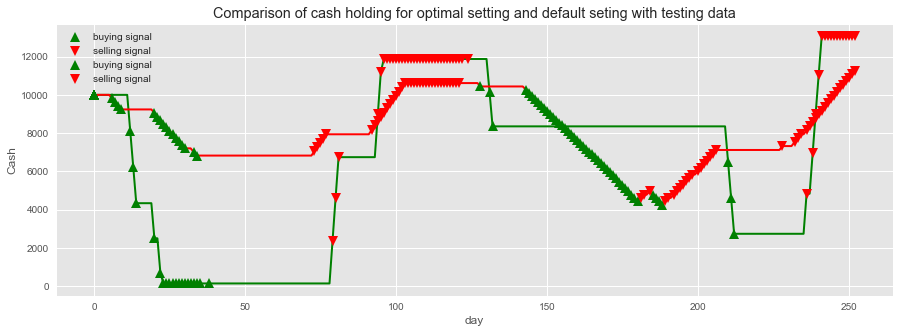

In [66]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money_optimal_testing, color='g', lw=2.)
plt.plot(states_money_optimal_testing, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy_optimal_testing)
plt.plot(states_money_optimal_testing, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell_optimal_testing)
plt.plot(states_money_default_testing, color='r', lw=2.)
plt.plot(states_money_default_testing, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy_default_testing)
plt.plot(states_money_default_testing, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell_default_testing)

plt.legend()
plt.title('Comparison of cash holding for optimal setting and default seting with testing data')
plt.xlabel('day')
plt.ylabel('Cash')
filename = prefix + 'Testing_Compare_Cash.png'
#plt.show()
plt.savefig(filename)

In [67]:
#X_Asset_testing['Adj Close']


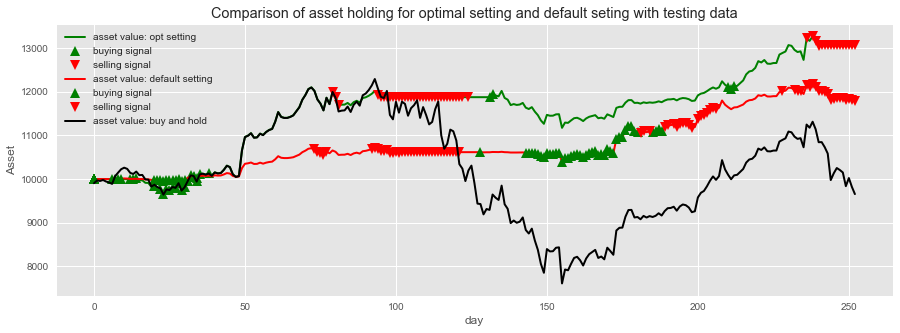

In [68]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_asset_optimal_testing, color='g', lw=2., label='asset value: opt setting')
plt.plot(states_asset_optimal_testing, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy_optimal_testing)
plt.plot(states_asset_optimal_testing, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell_optimal_testing)
plt.plot(states_asset_default_testing, color='r', lw=2., label='asset value: default setting')
plt.plot(states_asset_default_testing, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy_default_testing)
plt.plot(states_asset_default_testing, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell_default_testing)
plt.plot(np.asarray(X_Asset_testing['Adj Close']), color='k', lw=2., label='asset value: buy and hold')


plt.legend()
plt.title('Comparison of asset holding for optimal setting and default seting with testing data')
plt.xlabel('day')
plt.ylabel('Asset')
#plt.show()
filename = prefix +'Testing_Compare_Asset.png'
plt.savefig(filename)

In [69]:
pd_states_asset_optimal_testing=pd.DataFrame(states_asset_optimal_testing, columns=['AssetValue'], index=X_test.index) 
file_name_opt_test = 'dataset/'+Stock+'_opt_test.csv'
pd_states_asset_optimal_testing.to_csv(file_name_opt_test, sep=',', encoding='utf-8')

## Compute Sharpe Ratios and Sortino Ratios

In [70]:
sharpe_ratio_optimal_setting_test = get_sharpe_ratio_from_bankrate(states_asset_optimal_testing)
sharpe_ratio_default_setting_test = get_sharpe_ratio_from_bankrate(states_asset_default_testing)

sharpe_ratio_buy_and_hold_test = get_sharpe_ratio_from_bankrate(X_test)
sharpe_ratios = '''sharpe_ratio_optimal_setting_test ={0:.2f}%, sharpe_ratio_default_setting_test ={1:.2f}%, sharpe_ratio_buy_and_hold_test ={2:.2f}% '''
print(sharpe_ratios.format(sharpe_ratio_optimal_setting_test,sharpe_ratio_default_setting_test,sharpe_ratio_buy_and_hold_test))

sharpe_ratio_optimal_setting_test =12.29%, sharpe_ratio_default_setting_test =12.43%, sharpe_ratio_buy_and_hold_test =6.05% 


In [71]:
sortino_ratio_optimal_setting_test = get_sortino_from_bankrate(states_asset_optimal_testing)
sortino_ratio_default_setting_test = get_sortino_from_bankrate(states_asset_default_testing)

sortino_ratio_buy_and_hold_test = get_sortino_from_bankrate(X_test['Adj Close'])
sortino_ratios = '''sortino_ratio_optimal_setting_test ={0:.2f}%, sortino_ratio_default_setting_test={1:.2f}%, sortino_ratio_buy_and_hold_test ={2:.2f}%'''
print(sortino_ratios.format(sortino_ratio_optimal_setting_test,sortino_ratio_default_setting_test,sortino_ratio_buy_and_hold_test))

sortino_ratio_optimal_setting_test =22.87%, sortino_ratio_default_setting_test=22.75%, sortino_ratio_buy_and_hold_test =-0.11%


In [72]:
#insert into metadata (id, meta_name) Values
#	(1, 'Train_buy_and_hold'),
insert_metrics_setting(stock_id, 1,  0, 0,0, buy_and_hold_ROI_training, sharpe_ratio_buy_and_hold_train, sortino_ratio_buy_and_hold_train)
#	(2, 'Train_abcd_default'),
insert_metrics_setting(stock_id, 2,  4, 7,1, invest_default_training, sharpe_ratio_default_setting_train, sortino_ratio_default_setting_train)
#	(3, 'Train_abcd_opt'),
insert_metrics_setting(stock_id, 3,  skip_loop, ma, max_buy, invest_optimal_training, sharpe_ratio_optimal_setting_train, sortino_ratio_optimal_setting_train)


#	(4, 'Test_buy_and_hold'),
insert_metrics_setting(stock_id, 4, 0, 0,0, buy_and_hold_ROI_testing, sharpe_ratio_buy_and_hold_test, sortino_ratio_buy_and_hold_test)


#	(5, 'Test_abcd_default'),
insert_metrics_setting(stock_id, 5, 4, 7,1, invest_default_testing, sharpe_ratio_default_setting_test, sortino_ratio_default_setting_test)


#	(6, 'Test_abcd_opt');

insert_metrics_setting(stock_id, 6, skip_loop, ma, max_buy, invest_optimal_testing, sharpe_ratio_optimal_setting_test, sortino_ratio_optimal_setting_test)




connect
connect
connect
connect
connect
connect


 ##### TimeSeriesSplit not suitable for this study.
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = X_train['Adj Close'] #np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
#y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=2)
print(tscv)  
#TimeSeriesSplit(max_train_size=None, n_splits=2)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
